<a href="https://colab.research.google.com/github/EarnTHYPart/GAN-/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
device = 'cuda'

batch_size = 128
noise_dim = 64

#Parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Variables
epochs = 20

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([
    T.RandomRotation((-20 , 20)),
    T.ToTensor() # channel , height , width
])

In [5]:
train_set = datasets.MNIST('MNIST/', download = True , train = True , transform = train_augs )

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.7MB/s]


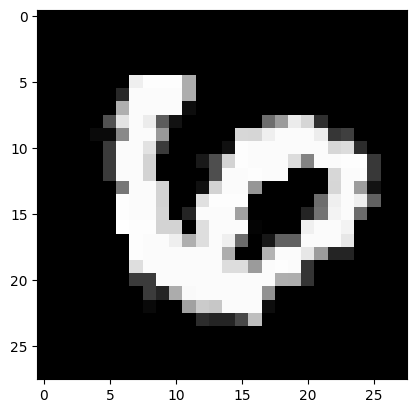

In [6]:
image , label = train_set[9000]

plt.imshow(image.squeeze() , cmap = 'gray')

# Load Dataset Into Batches

In [7]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [8]:
trainLoader = DataLoader(train_set , batch_size = batch_size , shuffle = True)

In [9]:
dataIter = iter(trainLoader)

images , _ = next(dataIter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [10]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

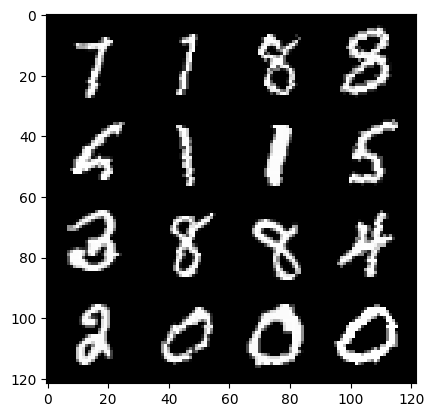

In [11]:
show_tensor_images(images , num_images = 16)

In [12]:
!pip install torchsummary

In [13]:
from torch import nn
from torchsummary import summary

In [14]:
def get_disc_block(in_channels , out_channels , kernel_size , stride):
  return nn.Sequential(
      nn.Conv2d(in_channels , out_channels , kernel_size , stride),
      nn.BatchNorm2d(out_channels ),
      nn.LeakyReLU(0.2)
  )


In [17]:
class Discriminator(nn.Module):

  def __init__(self, *args, **kwargs):
    super(Discriminator, self).__init__(*args, **kwargs)

    self.block1 = get_disc_block(1 , 16 ,(3,3),2)
    self.block2 = get_disc_block(16 , 32,(5,5),2)
    self.block3 = get_disc_block(32 , 64,(5,5),2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features= 64 , out_features= 1)

  def forward(self , images):
    x1 = self.block1(images)
    x2 = self.block2(x1)
    x3 = self.block3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [18]:
D = Discriminator()
D.to(device)

summary(D , input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [19]:
def get_gen_block(in_channels , out_channels , kernel_size , stride , final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels , out_channels , kernel_size , stride),
        nn.Tanh()
    )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels , out_channels , kernel_size , stride),
      nn.BatchNorm2d(out_channels ),
      nn.ReLU()
  )

In [24]:
class Generator(nn.Module):

  def __init__(self , noise_dim):
    super(Generator , self).__init__()

    self.noise_dim = noise_dim
    self.block1 = get_gen_block(noise_dim ,256 , (3,3) , 2)
    self.block2 = get_gen_block(256 , 128 , (4,4) , 1)
    self.block3 = get_gen_block(128 , 64 , (3,3) , 2)
    self.block4 = get_gen_block(64 , 1 , (4,4) , 2 , final_block = True)

  def forward(self , r_noise_vec):
    x = r_noise_vec.view(-1 , self.noise_dim , 1 , 1)

    x1 = self.block1(x)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    x4 = self.block4(x3)

    return x4

In [25]:
G = Generator(noise_dim)
G.to(device)

summary(G , input_size = (1  , noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [26]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [27]:
D.apply(weights_init)
G.apply(weights_init)

Generator(
  (block1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

# Create Loss Function and Load Optimizer

In [28]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred , ground_truth)

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred , ground_truth)

In [29]:
D_opt = torch.optim.Adam(D.parameters() , lr = lr , betas = (beta_1 , beta_2))
G_opt = torch.optim.Adam(D.parameters() , lr = lr , betas = (beta_1 , beta_2))

# Training Loop

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya